In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Flower_Color.zip

--2023-12-21 19:42:00--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Flower_Color.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.160.139, 52.219.66.124, 52.219.62.104, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.160.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52779776 (50M) [application/x-zip-compressed]
Saving to: 'Flower_Color.zip.3'

Flower_Color.zip.3  100%[===================>]  50.33M  15.0MB/s    in 3.4s    

2023-12-21 19:42:04 (15.0 MB/s) - 'Flower_Color.zip.3' saved [52779776/52779776]



In [44]:
!unzip -qo Flower_Color.zip

In [45]:
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU
import seaborn as sns

In [46]:
def image_to_tensor(img_path):
    img = keras_image.load_img("Flower Color/flower_images/" + img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

In [47]:


def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)



In [48]:
ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv("Flower Color/flower_images/flower_labels.csv")
files = data['file']
targets = data['label'].values
tensors = data_to_tensor(files);

100%|██████████| 210/210 [00:00<00:00, 549.02it/s]


In [49]:
data.head()

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0


In [50]:
tensors.shape

(210, 128, 128, 3)

In [51]:
targets.shape

(210,)

In [52]:
# Name list
names = ['phlox', 'rose', 'calendula', 'iris', 'max chrysanthemum', 
         'bellflower', 'viola', 'rudbeckia laciniata', 'peony', 'aquilegia']

In [53]:
def display_images(img_path, ax):
    img = cv2.imread("Flower Color/flower_images/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

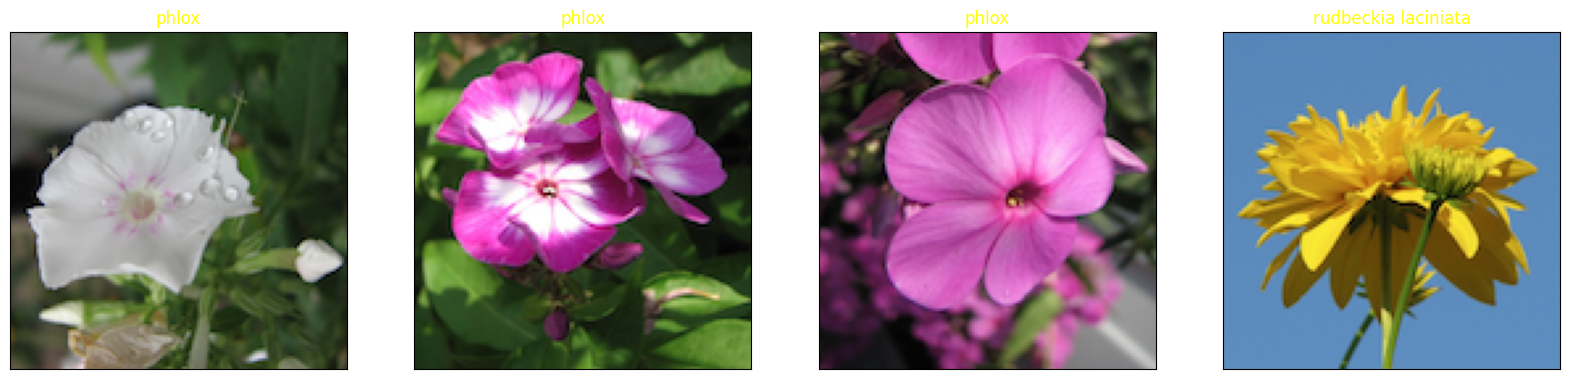

In [54]:
fig = plt.figure(figsize=(20, 10))
for i in range(4):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.set_title(names[targets[i+10]], color='yellow')
    display_images(files[i+10], ax)

In [55]:
# Create h5 file and save data
with h5py.File('FlowerColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.close()

In [56]:
# Read the h5 file
f = h5py.File('FlowerColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['images', 'labels']

In [57]:
tensors = np.array(f[keys[0]])
targets = np.array(f[keys[1]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (210, 128, 128, 3)
Target shape (210,)


In [58]:
# Create a csv file and save data
images_csv = tensors.reshape(210,128*128*3)
np.savetxt("flower_images.csv", images_csv, fmt='%i', delimiter=",")

In [59]:
# Read the pandas dataframe from csv
data_images = pd.read_csv("flower_images.csv", header=None)
data_images.head()

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,13,22,10,14,23,9,16,24,10,16,...,44,59,38,38,26,25,16,117,74,78
1,38,49,30,37,50,30,38,52,30,40,...,9,9,10,8,7,7,7,5,5,5
2,65,83,48,72,87,58,74,90,62,81,...,35,52,70,38,56,74,41,58,76,42
3,162,53,102,147,66,91,156,80,97,169,...,69,105,44,67,103,43,68,103,43,68
4,193,52,78,194,51,76,195,58,85,197,...,199,253,179,200,248,163,189,229,120,154


In [60]:
data_images.iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
0,13,22,10,14,23,9,16,24,10,16
1,38,49,30,37,50,30,38,52,30,40
2,65,83,48,72,87,58,74,90,62,81
3,162,53,102,147,66,91,156,80,97,169
4,193,52,78,194,51,76,195,58,85,197
5,53,76,55,53,76,55,53,77,56,53
6,8,9,8,8,9,9,9,9,9,8
7,9,9,8,9,9,9,8,8,8,8
8,195,127,169,188,118,160,135,76,101,55
9,7,7,7,8,7,7,8,9,8,9


In [61]:
data_images.shape

(210, 49152)

In [62]:
# Read image tensors from the dataframe
tensors = data_images.values
tensors.shape

(210, 49152)

In [63]:
tensors = tensors.reshape(-1,128,128,3)
tensors.shape

(210, 128, 128, 3)

In [64]:
tensors = tensors.astype('float32')/255

In [65]:
targets = to_categorical(targets, 10)

In [66]:
x_train, x_test, y_train, y_test = train_test_split(tensors, targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [67]:
x_train.shape, y_train.shape

((168, 128, 128, 3), (168, 10))

In [68]:
x_test.shape, y_test.shape

((21, 128, 128, 3), (21, 10))

In [69]:
 x_valid.shape, y_valid.shape

((21, 128, 128, 3), (21, 10))

Label:  rose


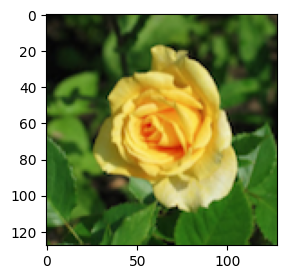

In [70]:
# Read and display a tensor
print('Label: ', names[np.argmax(y_train[7])])
plt.figure(figsize=(3,3))
plt.imshow((x_train[7]));

In [71]:
def model():
    model = Sequential()

    model.add(Conv2D(128, (3, 3), input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

In [72]:
# To save the best model
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)

# To reduce learning rate dynamically
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 61, 61, 128)       0         
                                                        

In [74]:
history = model.fit(x_train, y_train, 
                    epochs=75, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer,lr_reduction])

Epoch 1/75

Epoch 1: val_loss improved from inf to 2.29027, saving model to weights.best.model.hdf5
6/6 - 12s - loss: 2.3228 - accuracy: 0.0952 - val_loss: 2.2903 - val_accuracy: 0.1905 - lr: 0.0010 - 12s/epoch - 2s/step
Epoch 2/75


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2.29027 to 2.28501, saving model to weights.best.model.hdf5
6/6 - 10s - loss: 2.2568 - accuracy: 0.1667 - val_loss: 2.2850 - val_accuracy: 0.0952 - lr: 0.0010 - 10s/epoch - 2s/step
Epoch 3/75

Epoch 3: val_loss improved from 2.28501 to 2.22366, saving model to weights.best.model.hdf5
6/6 - 10s - loss: 2.1826 - accuracy: 0.1964 - val_loss: 2.2237 - val_accuracy: 0.0952 - lr: 0.0010 - 10s/epoch - 2s/step
Epoch 4/75

Epoch 4: val_loss improved from 2.22366 to 2.14749, saving model to weights.best.model.hdf5
6/6 - 10s - loss: 2.1110 - accuracy: 0.2381 - val_loss: 2.1475 - val_accuracy: 0.3810 - lr: 0.0010 - 10s/epoch - 2s/step
Epoch 5/75

Epoch 5: val_loss improved from 2.14749 to 2.05892, saving model to weights.best.model.hdf5
6/6 - 10s - loss: 1.9815 - accuracy: 0.3333 - val_loss: 2.0589 - val_accuracy: 0.3810 - lr: 0.0010 - 10s/epoch - 2s/step
Epoch 6/75

Epoch 6: val_loss improved from 2.05892 to 2.01369, saving model to weights.best.model.hdf5
6/6 - 1

In [75]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)

dg_history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                 steps_per_epoch = len(x_train)//64, epochs=7, verbose=2, 
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[checkpointer,lr_reduction])

/tmp/ipykernel_41/2513234589.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  dg_history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),


Epoch 1/7

Epoch 1: val_loss did not improve from 0.43798
2/2 - 9s - loss: 0.3063 - accuracy: 0.8828 - val_loss: 0.4633 - val_accuracy: 0.8095 - lr: 4.0000e-05 - 9s/epoch - 4s/step
Epoch 2/7

Epoch 2: val_loss did not improve from 0.43798
2/2 - 7s - loss: 0.2943 - accuracy: 0.8846 - val_loss: 0.4675 - val_accuracy: 0.8095 - lr: 4.0000e-05 - 7s/epoch - 3s/step
Epoch 3/7

Epoch 3: val_loss did not improve from 0.43798
2/2 - 7s - loss: 0.3242 - accuracy: 0.8462 - val_loss: 0.4738 - val_accuracy: 0.8095 - lr: 4.0000e-05 - 7s/epoch - 4s/step
Epoch 4/7

Epoch 4: val_loss did not improve from 0.43798
2/2 - 7s - loss: 0.2432 - accuracy: 0.8942 - val_loss: 0.4780 - val_accuracy: 0.8095 - lr: 4.0000e-05 - 7s/epoch - 3s/step
Epoch 5/7

Epoch 5: val_loss did not improve from 0.43798
2/2 - 8s - loss: 0.3583 - accuracy: 0.8906 - val_loss: 0.4831 - val_accuracy: 0.8095 - lr: 4.0000e-05 - 8s/epoch - 4s/step
Epoch 6/7

Epoch 6: val_loss did not improve from 0.43798

Epoch 6: ReduceLROnPlateau reducing 

In [76]:
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')

In [77]:
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

1/1 [==============================] - 0s 341ms/step - loss: 0.7051 - accuracy: 0.7143


[0.7050865292549133, 0.7142857313156128]

In [78]:
# Calculate classification accuracy on the training set
score = model.evaluate(x_train, y_train)
score

6/6 [==============================] - 3s 441ms/step - loss: 0.1625 - accuracy: 0.9940


[0.1624746173620224, 0.9940476417541504]

In [79]:
# Calculate classification accuracy on the validation set
score = model.evaluate(x_valid, y_valid)
score

1/1 [==============================] - 0s 342ms/step - loss: 0.4380 - accuracy: 0.9048


[0.43798279762268066, 0.9047619104385376]

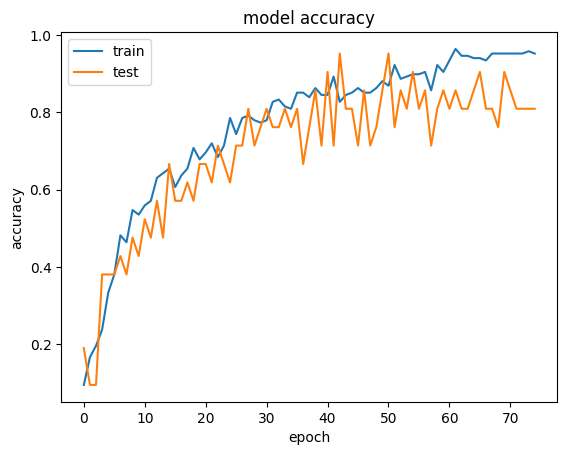

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

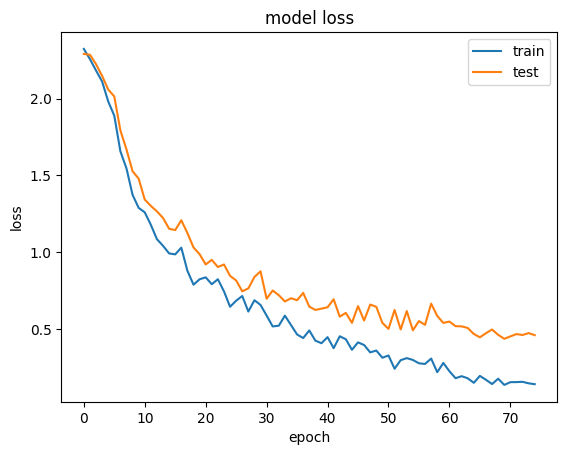

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [82]:
model.save('model.h5')

In [83]:
model1 = load_model('model.h5')

In [84]:
# Model predictions for the testing dataset
y_test_predict = model1.predict(x_test)

1/1 [==============================] - 0s 464ms/step


In [85]:
y_test_predict = np.argmax(y_test_predict,axis=1)

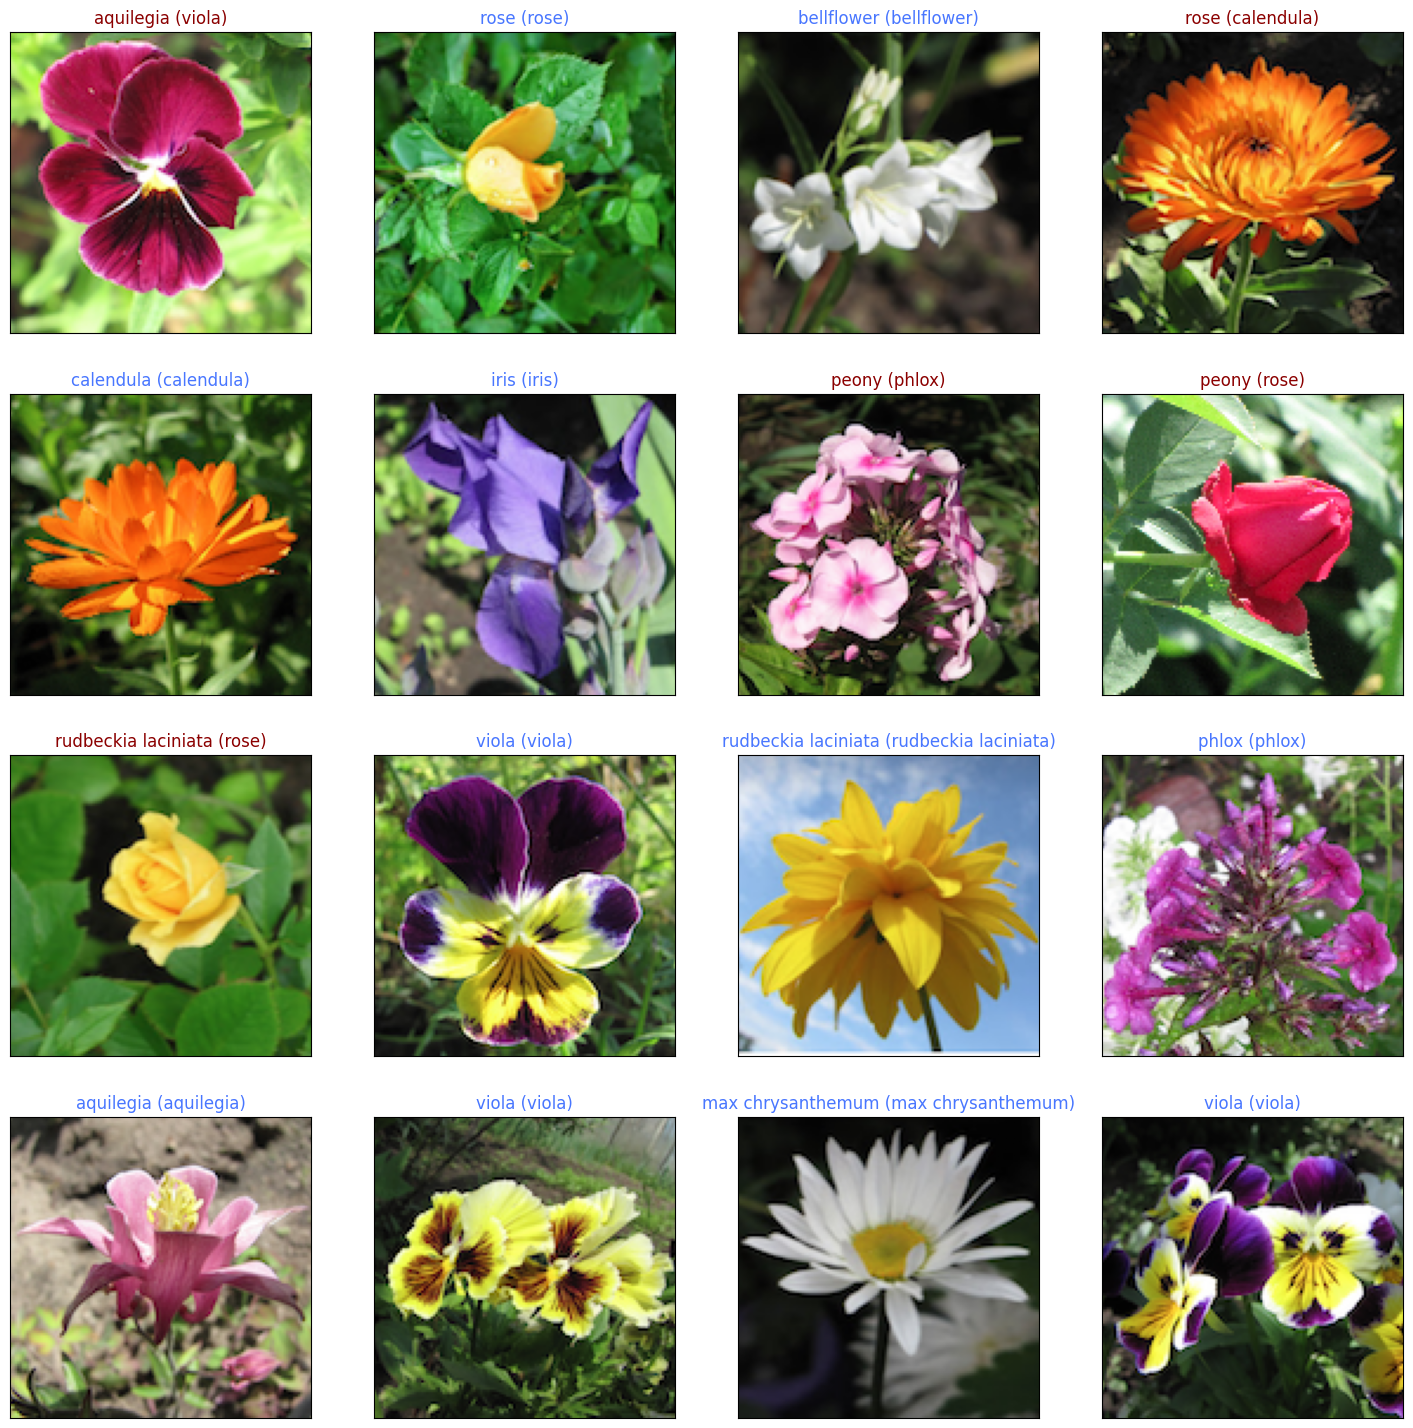

In [86]:

# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))



In [87]:
y_test_orig = []

In [88]:
for i in y_test:
  y_test_orig.append(np.argmax(i)) 

In [89]:
y_test_orig = np.array(y_test_orig)

In [90]:
y_test_orig

array([6, 3, 4, 9, 2, 0, 7, 6, 1, 2, 4, 0, 6, 0, 3, 1, 6, 5, 5, 7, 1])

In [91]:
y_test_predict

array([6, 5, 4, 9, 2, 0, 7, 9, 8, 1, 4, 8, 6, 0, 3, 7, 6, 5, 5, 7, 1])

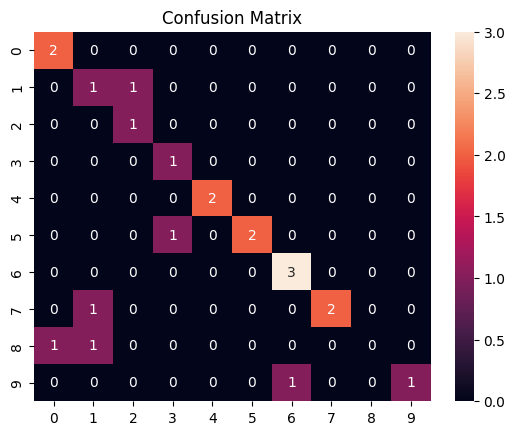

In [92]:
#Plotting a confusion matrix
cnf = confusion_matrix(y_test_predict,y_test_orig)


df_cnf = pd.DataFrame(cnf, range(10), range(10))
sns.heatmap(df_cnf, annot = True)
plt.title("Confusion Matrix")
plt.show()

In [93]:
!deepCC model.h5

/bin/bash: deepCC: command not found
